In [10]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 101)

In [11]:
raw = pd.read_csv('../data/interim/merged_19.csv')

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
for col in raw.columns:
    print(col)

Unnamed: 0
RCDTS
Type
School Name
District
City
County
District Type
District Size
School Type
Grades Served
Summative Designation
State Senate District
State Representative District
# Student Enrollment
% Student Enrollment - White
% Student Enrollment - Black or African American
% Student Enrollment - Hispanic or Latino
% Student Enrollment - Asian
% Student Enrollment - Native Hawaiian or Other Pacific Islander
% Student Enrollment - American Indian or Alaska Native
% Student Enrollment - Two or More Races
% Student Enrollment - EL
% Student Enrollment - IEP
% Student Enrollment - Low Income
% Student Enrollment - Homeless
Total Number of School Days
Student Attendance Rate
Student Attendance Rate - Male
Student Attendance Rate - Female
Student Attendance Rate - White
Student Attendance Rate - Black or African American
Student Attendance Rate - Hispanic or Latino
Student Attendance Rate - Asian
Student Attendance Rate - Native Hawaiian or Other Pacific Islander
Student Attendance Ra

In [13]:
raw.Type.value_counts()

School       3888
District      865
Statewide       1
Name: Type, dtype: int64

# Districts

## Nulls

In [14]:
districts = raw[raw.Type == 'District']

In [15]:
all_nulls = districts.apply(lambda row: row.isnull().all())
no_null_columns = districts.drop(columns=all_nulls[all_nulls].index)

In [16]:
no_null_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 0 to 4732
Columns: 553 entries, Unnamed: 0 to Year
dtypes: float64(544), int64(2), object(7)
memory usage: 3.7+ MB


In [17]:
no_null_columns.apply(lambda row: row.isnull().any()).sum()
# 547 / 553 columns have at least one null value

547

In [18]:
no_null_columns.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 0 to 4732
Data columns (total 553 columns):
Unnamed: 0                                                                                         865 non-null int64
RCDTS                                                                                              865 non-null object
Type                                                                                               865 non-null object
District                                                                                           865 non-null object
City                                                                                               859 non-null object
County                                                                                             859 non-null object
District Type                                                                                      858 non-null object
District Size                                                

- lots of nulls in race (perhaps they omit if it's zero - could check if they add up to 1)
    - same for attendence rate by race (altho numbers don't exactly line up)
    - and mobility rate
- high school drop out rate is surprisinly only half full (417) - (min is 0.1 so plausible assumption)
    - same by race questions
- high school graduation rate only has 479 results (unclear why) - so only 480 districts across HS in database
    - 477 5 year, 475 for 6th year
    - same issues with race
- avg class size for high school is also only like 476 (perhaps districts don't have high schools?????)
- avg min per day math/sci/engl for grades 3,6,8 at ~760 (perhaps only those have those grades? matches avg class size metrics)
    - DISTRICTS DON'T HAVE ANY "GRADES SERVED" DATA - hmmm
- same potential issue with race of teachers
- potentially same issue with avg teaching exp with high/low poverty
- only 483 pupil/teacher ratio HS (has zeros, how would that be zero - no high school students?)
- also only 766 pupil/teach ratio elementary
- Community College remediation (471)




-------- Columns with Few Nulls ------------
avg teaching exp (862)
phys edu (860)
truancy(860)
mobility rate/attendence rate/school days (860)
enrollment/district info (865)
Bach/Master degree
pupil ratio, teacher sal, admin sal, retention rate, princ turnover, teacher attendence/eval
chronic absenteeism


----- very low -----
AP/IB classes



In [19]:
no_null_columns['Pupil Teacher Ratio - High School'].describe()

count    483.000000
mean      15.560870
std        4.797192
min        0.000000
25%       12.400000
50%       16.200000
75%       18.900000
max       33.900000
Name: Pupil Teacher Ratio - High School, dtype: float64

### How Many High Schools Are There?

In [20]:
high_schools = raw[
    (raw.Type == 'School') &
    ~raw['Grades Served'].str.contains('12', na=False) &
    (raw['Grades Served'].str.contains('11') |
    raw['Grades Served'].str.contains('10') |
    raw['Grades Served'].str.contains('9'))
]

In [21]:
high_schools['Grades Served'].head()
# 5 high schools have at least one grade but don't go up to 12

131      6 7 8 9
194            9
516            9
699            9
1506        9 10
Name: Grades Served, dtype: object

In [22]:
raw[raw.District.isin(high_schools['District']) & (raw.District != 'City of Chicago SD 299')][['District', 'Grades Served']]
# but they have a different high school that does go up to 12

,District,Grades Served
129,Effingham CUSD 40,NaN
130,Effingham CUSD 40,9 10 11 12
131,Effingham CUSD 40,6 7 8 9
132,Effingham CUSD 40,PK 2 3 4 5 6
133,Effingham CUSD 40,PK K
134,Effingham CUSD 40,1 2
192,Harlem UD 122,NaN
193,Harlem UD 122,9 10 11 12
194,Harlem UD 122,9
195,Harlem UD 122,7 8


In [23]:
districts_with_high_schools = raw[(raw.Type == 'School') & raw['Grades Served'].str.contains('12', na=False)].District.unique()
len(districts_with_high_schools)
# Seems like this is a good estimate for the number of districts with high schools

480

In [24]:
high_schools = raw[
    (raw.Type == 'School') &
    raw['Grades Served'].str.contains('13', na=False)
]

### What is up with 483 have pupil/teacher for HS but only 480 HS?

In [25]:
raw[~raw['Pupil Teacher Ratio - High School'].isnull() & ~raw.District.isin(districts_with_high_schools)]

,Unnamed: 0,RCDTS,Type,School Name,District,City,County,District Type,District Size,School Type,...,Black or African American Students SAT ELA Participation %,Hispanic or Latino Students SAT ELA Participation %,Asian Students SAT ELA Participation %,Native Hawaiian or Other Pacific Islander Students SAT ELA Participation %,American Indian or Alaska Native Students SAT ELA Participation %,Two or More Race Students SAT ELA Participation %,IEP Students SAT ELA Participation %,EL Students SAT ELA Participation %,Low Income Students SAT ELA Participation %,Year
921,921,70161550020000,District,NaN,Calumet City SD 155,Calumet City,Cook,ELEMENTARY,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
925,925,70161560020000,District,NaN,Lincoln ESD 156,Calumet City,Cook,ELEMENTARY,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2133,2133,190220130020000,District,NaN,Bloomingdale SD 13,Bloomingdale,Dupage,ELEMENTARY,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2202,2202,190220580020000,District,NaN,Downers Grove GSD 58,Downers Grove,Dupage,ELEMENTARY,LARGE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
4327,4327,540920010260000,District,NaN,Bismarck Henning CUSD,Bismarck,Vermilion,UNIT,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
4338,4338,540920070260000,District,NaN,Rossville-Alvin CUSD 7,Rossville,Vermilion,UNIT,SMALL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
4753,4753,NaN,Statewide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.4,97.4,99.5,98.1,97.5,97.6,95.7,96.3,96.6,2018


In [26]:
raw[~raw['Pupil Teacher Ratio - High School'].isnull() & (raw['District Type'] == 'ELEMENTARY')]

,Unnamed: 0,RCDTS,Type,School Name,District,City,County,District Type,District Size,School Type,...,Black or African American Students SAT ELA Participation %,Hispanic or Latino Students SAT ELA Participation %,Asian Students SAT ELA Participation %,Native Hawaiian or Other Pacific Islander Students SAT ELA Participation %,American Indian or Alaska Native Students SAT ELA Participation %,Two or More Race Students SAT ELA Participation %,IEP Students SAT ELA Participation %,EL Students SAT ELA Participation %,Low Income Students SAT ELA Participation %,Year
921,921,70161550020000,District,NaN,Calumet City SD 155,Calumet City,Cook,ELEMENTARY,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
925,925,70161560020000,District,NaN,Lincoln ESD 156,Calumet City,Cook,ELEMENTARY,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2133,2133,190220130020000,District,NaN,Bloomingdale SD 13,Bloomingdale,Dupage,ELEMENTARY,MEDIUM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2202,2202,190220580020000,District,NaN,Downers Grove GSD 58,Downers Grove,Dupage,ELEMENTARY,LARGE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018


In [27]:
raw[raw.Type == 'District']['District Type'].value_counts()

UNIT           388
ELEMENTARY     371
HIGH SCHOOL     99
Name: District Type, dtype: int64

In [28]:
raw[(raw.Type == 'School') & (raw['District Type'] == 'UNIT')]['Grades Served'].value_counts()

 9 10 11 12                        472
PK K 1 2 3 4 5 6 7 8               387
 K 1 2 3 4 5                       311
 6 7 8                             233
PK K 1 2 3 4 5                     159
 K 1 2 3 4 5 6 7 8                 103
PK K 1 2 3 4 5 6                    75
 K 1 2 3 4 5 6                      71
 7 8                                67
 5 6 7 8                            59
PK                                  58
PK K 1 2 3 4                        51
 7 8 9 10 11 12                     47
 K 1 2 3 4                          44
PK K 1 2                            44
 3 4 5                              34
 6 7 8 9 10 11 12                   25
PK K 1                              21
PK K 1 2 3                          21
 K 1 2 3                            15
 4 5 6                              15
 4 5                                15
 2 3                                11
 K 1 2                              11
 1 2 3 4 5                          11
PK K                     

In [29]:
raw[(raw.Type == 'School') & (raw['District Type'] == 'UNIT')]['Grades Served'].value_counts()

 9 10 11 12                        472
PK K 1 2 3 4 5 6 7 8               387
 K 1 2 3 4 5                       311
 6 7 8                             233
PK K 1 2 3 4 5                     159
 K 1 2 3 4 5 6 7 8                 103
PK K 1 2 3 4 5 6                    75
 K 1 2 3 4 5 6                      71
 7 8                                67
 5 6 7 8                            59
PK                                  58
PK K 1 2 3 4                        51
 7 8 9 10 11 12                     47
 K 1 2 3 4                          44
PK K 1 2                            44
 3 4 5                              34
 6 7 8 9 10 11 12                   25
PK K 1                              21
PK K 1 2 3                          21
 K 1 2 3                            15
 4 5 6                              15
 4 5                                15
 2 3                                11
 K 1 2                              11
 1 2 3 4 5                          11
PK K                     

In [30]:
just_high_schools = raw[(raw.Type == 'School') & raw['Grades Served'].str.contains('12', na=False)]

In [31]:
just_high_schools[just_high_schools['District Type'] == 'ELEMENTARY']

,Unnamed: 0,RCDTS,Type,School Name,District,City,County,District Type,District Size,School Type,...,Black or African American Students SAT ELA Participation %,Hispanic or Latino Students SAT ELA Participation %,Asian Students SAT ELA Participation %,Native Hawaiian or Other Pacific Islander Students SAT ELA Participation %,American Indian or Alaska Native Students SAT ELA Participation %,Two or More Race Students SAT ELA Participation %,IEP Students SAT ELA Participation %,EL Students SAT ELA Participation %,Low Income Students SAT ELA Participation %,Year


In [32]:
# There are 4 elementary school districts that have a measure for HS Pupil Ratio
# No school in an "Elementary" school district serves any grade 9-12
# so really missing one piece of data (483 - 4 errors => one of the 480 districts with high schools)

# Conclusion: can limit to the 480 districts with High Schools

### How do the nulls look within Districts That Have High Schools?

In [33]:
high_districts = no_null_columns[no_null_columns.District.isin(just_high_schools.District.unique())]

In [34]:
high_districts.columns = [x.replace(' ', '_').replace('-', '').lower() for x in high_districts.columns]

In [35]:
high_districts.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 0 to 4732
Data columns (total 553 columns):
unnamed:_0                                                                                         480 non-null int64
rcdts                                                                                              480 non-null object
type                                                                                               480 non-null object
district                                                                                           480 non-null object
city                                                                                               475 non-null object
county                                                                                             475 non-null object
district_type                                                                                      475 non-null object
district_size                                                

- student enrollment (sum to 1)
- student attendence (sum to 1)
- student mobility (sum to 1)
- student high school dropout rate (sum to 1)
- high school grad rate (4/5/6)
- teacher race


### Do sum of % student enrollments equal 100?

In [37]:
high_districts['%_student_enrollment__white'] +\
high_districts['%_student_enrollment__black_or_african_american'] +\
high_districts['%_student_enrollment__hispanic_or_latino'] +\
high_districts['%_student_enrollment__asian'] +\
high_districts['%_student_enrollment__native_hawaiian_or_other_pacific_islander'] +\
high_districts['%_student_enrollment__american_indian_or_alaska_native'] +\
high_districts['%_student_enrollment__two_or_more_races']

0        NaN
3        NaN
6        NaN
11       NaN
15       NaN
        ... 
4708     NaN
4717     NaN
4723     NaN
4728     NaN
4732    99.9
Length: 480, dtype: float64

In [38]:
just_race = high_districts[[x for x in high_districts.columns if '%_student_enrollment' in x][:-4]]

In [39]:
just_race.fillna(value=0).agg('sum', axis=1).describe([0, 0.005, 0.01, 0.02, 0.25])

count    480.000000
mean      98.870000
std        1.317434
min       91.200000
0%        91.200000
0.5%      93.316000
1%        94.537000
2%        95.258000
25%       98.400000
50%       99.300000
max      100.100000
dtype: float64

In [40]:
# Assume blanks are zeros in most cases

### Assume SAT will be explanatory variable

In [41]:
no_sat_data = high_districts[high_districts['sat_math_total_students_level_1_%'].isnull() &
                             high_districts['sat_reading_total_students_level_1_%'].isnull() &
                             high_districts['sat_reading_total_students_level_4_%'].isnull() &
                             high_districts['sat_math_total_students_level_4_%'].isnull()
                            ]


In [42]:
with_sat = high_districts.dropna(subset=['sat_math_total_students_level_1_%'])
# there are 6 with no values and they all don't have values for that single column

In [43]:
with_sat.shape

(474, 553)

### Assume missing values are zero

In [44]:
column_includes_na_zero = [
    'sat_math_participation',
    'sat_ela_participation',
    '%_student_enrollment',
    'student_attendance_rate_', # remake null for 4 where the total student_attendance_rate is na
    'student_mobility_rate_',
    'high_school_dropout_rate', # assuming null means no student dropped out for that district (63/480)
    'high_school_4year_graduation_rate_', # remake null for 2 where the total rate is na
    '%_of_teachers_', # remake null for dist with null white/fte/exp/bach/masters (3/480)
    'chronic_absenteeism_', # remake null for for 4 where chronic_absenteeism is na
    'sat_reading_total',
    'sat_math_total'
]

In [45]:
col_fill_zero = [x for x in with_sat.columns if any([y in x for y in column_includes_na_zero])]

In [46]:
col_fill_zero

['%_student_enrollment__white',
 '%_student_enrollment__black_or_african_american',
 '%_student_enrollment__hispanic_or_latino',
 '%_student_enrollment__asian',
 '%_student_enrollment__native_hawaiian_or_other_pacific_islander',
 '%_student_enrollment__american_indian_or_alaska_native',
 '%_student_enrollment__two_or_more_races',
 '%_student_enrollment__el',
 '%_student_enrollment__iep',
 '%_student_enrollment__low_income',
 '%_student_enrollment__homeless',
 'student_attendance_rate__male',
 'student_attendance_rate__female',
 'student_attendance_rate__white',
 'student_attendance_rate__black_or_african_american',
 'student_attendance_rate__hispanic_or_latino',
 'student_attendance_rate__asian',
 'student_attendance_rate__native_hawaiian_or_other_pacific_islander',
 'student_attendance_rate__american_indian_or_alaska_native',
 'student_attendance_rate__two_or_more_races',
 'student_attendance_rate__el',
 'student_mobility_rate__male',
 'student_mobility_rate__female',
 'student_mobili

In [47]:
col_fill_zero.remove('high_school_4year_graduation_rate__total')

In [48]:
with_sat[col_fill_zero] = with_sat[col_fill_zero].fillna(value=0)

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Remove any column with less than 400 data points

In [49]:
few_nulls = with_sat.dropna(thresh=len(with_sat) - 80, axis=1)

In [50]:
few_nulls.shape
# removed ~40% of the columns

(474, 337)

# Duplicates

In [51]:
few_nulls.groupby('district').agg('count').rcdts.value_counts()

1    474
Name: rcdts, dtype: int64

# Understand Distributions and Correlations

In [65]:
%reload_ext autoreload
%autoreload 1
%aimport utilities.eda

from utilities.eda import eda_column_subset

## Student Demos

In [53]:
student_demo_cols = [
    '#_student_enrollment',
    '%_student_enrollment__white',
    '%_student_enrollment__black_or_african_american',
    '%_student_enrollment__homeless',
    '%_student_enrollment__low_income',
    '%_student_enrollment__iep',
    '%_student_enrollment__el',
    'student_attendance_rate',
    'student_mobility_rate',
    'student_chronic_truancy_rate',
]

,#_student_enrollment,%_student_enrollment__white,%_student_enrollment__black_or_african_american,%_student_enrollment__homeless,%_student_enrollment__low_income,%_student_enrollment__iep,%_student_enrollment__el,student_attendance_rate,student_mobility_rate,student_chronic_truancy_rate
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,3088.805907,78.934177,6.211392,1.858650,42.799789,15.314768,2.532068,94.071519,8.154219,6.048101
std,17433.908765,24.157936,15.661100,2.968634,18.529260,3.365814,5.689137,1.934501,3.883836,8.359462
min,124.000000,0.000000,0.000000,0.000000,2.100000,0.000000,0.000000,78.700000,1.000000,0.000000
10%,355.300000,42.290000,0.000000,0.000000,18.050000,11.500000,0.000000,92.300000,3.900000,0.800000
25%,529.500000,71.625000,0.000000,0.000000,30.025000,12.800000,0.000000,93.600000,5.500000,1.625000
50%,992.500000,90.550000,0.800000,0.800000,42.650000,15.000000,0.000000,94.500000,7.800000,3.550000
75%,2227.750000,94.800000,3.775000,2.400000,54.100000,17.475000,2.300000,95.100000,10.200000,7.475000
90%,5674.400000,96.400000,15.240000,5.300000,64.470000,20.000000,7.700000,95.700000,12.470000,13.450000
max,372214.000000,100.000000,100.000000,31.400000,99.600000,25.900000,39.000000,98.200000,35.700000,85.800000


<Figure size 2880x2880 with 0 Axes>

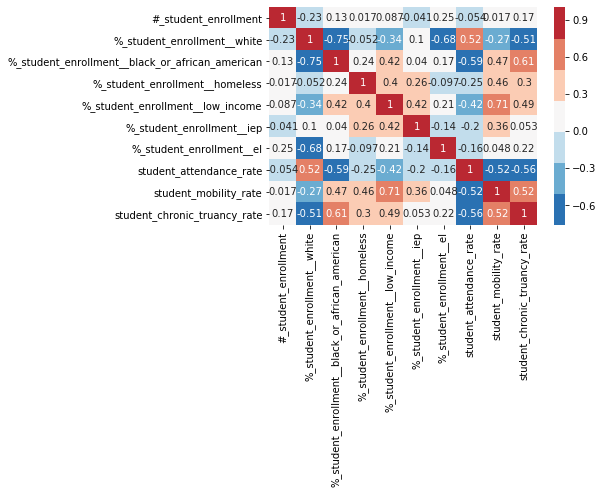

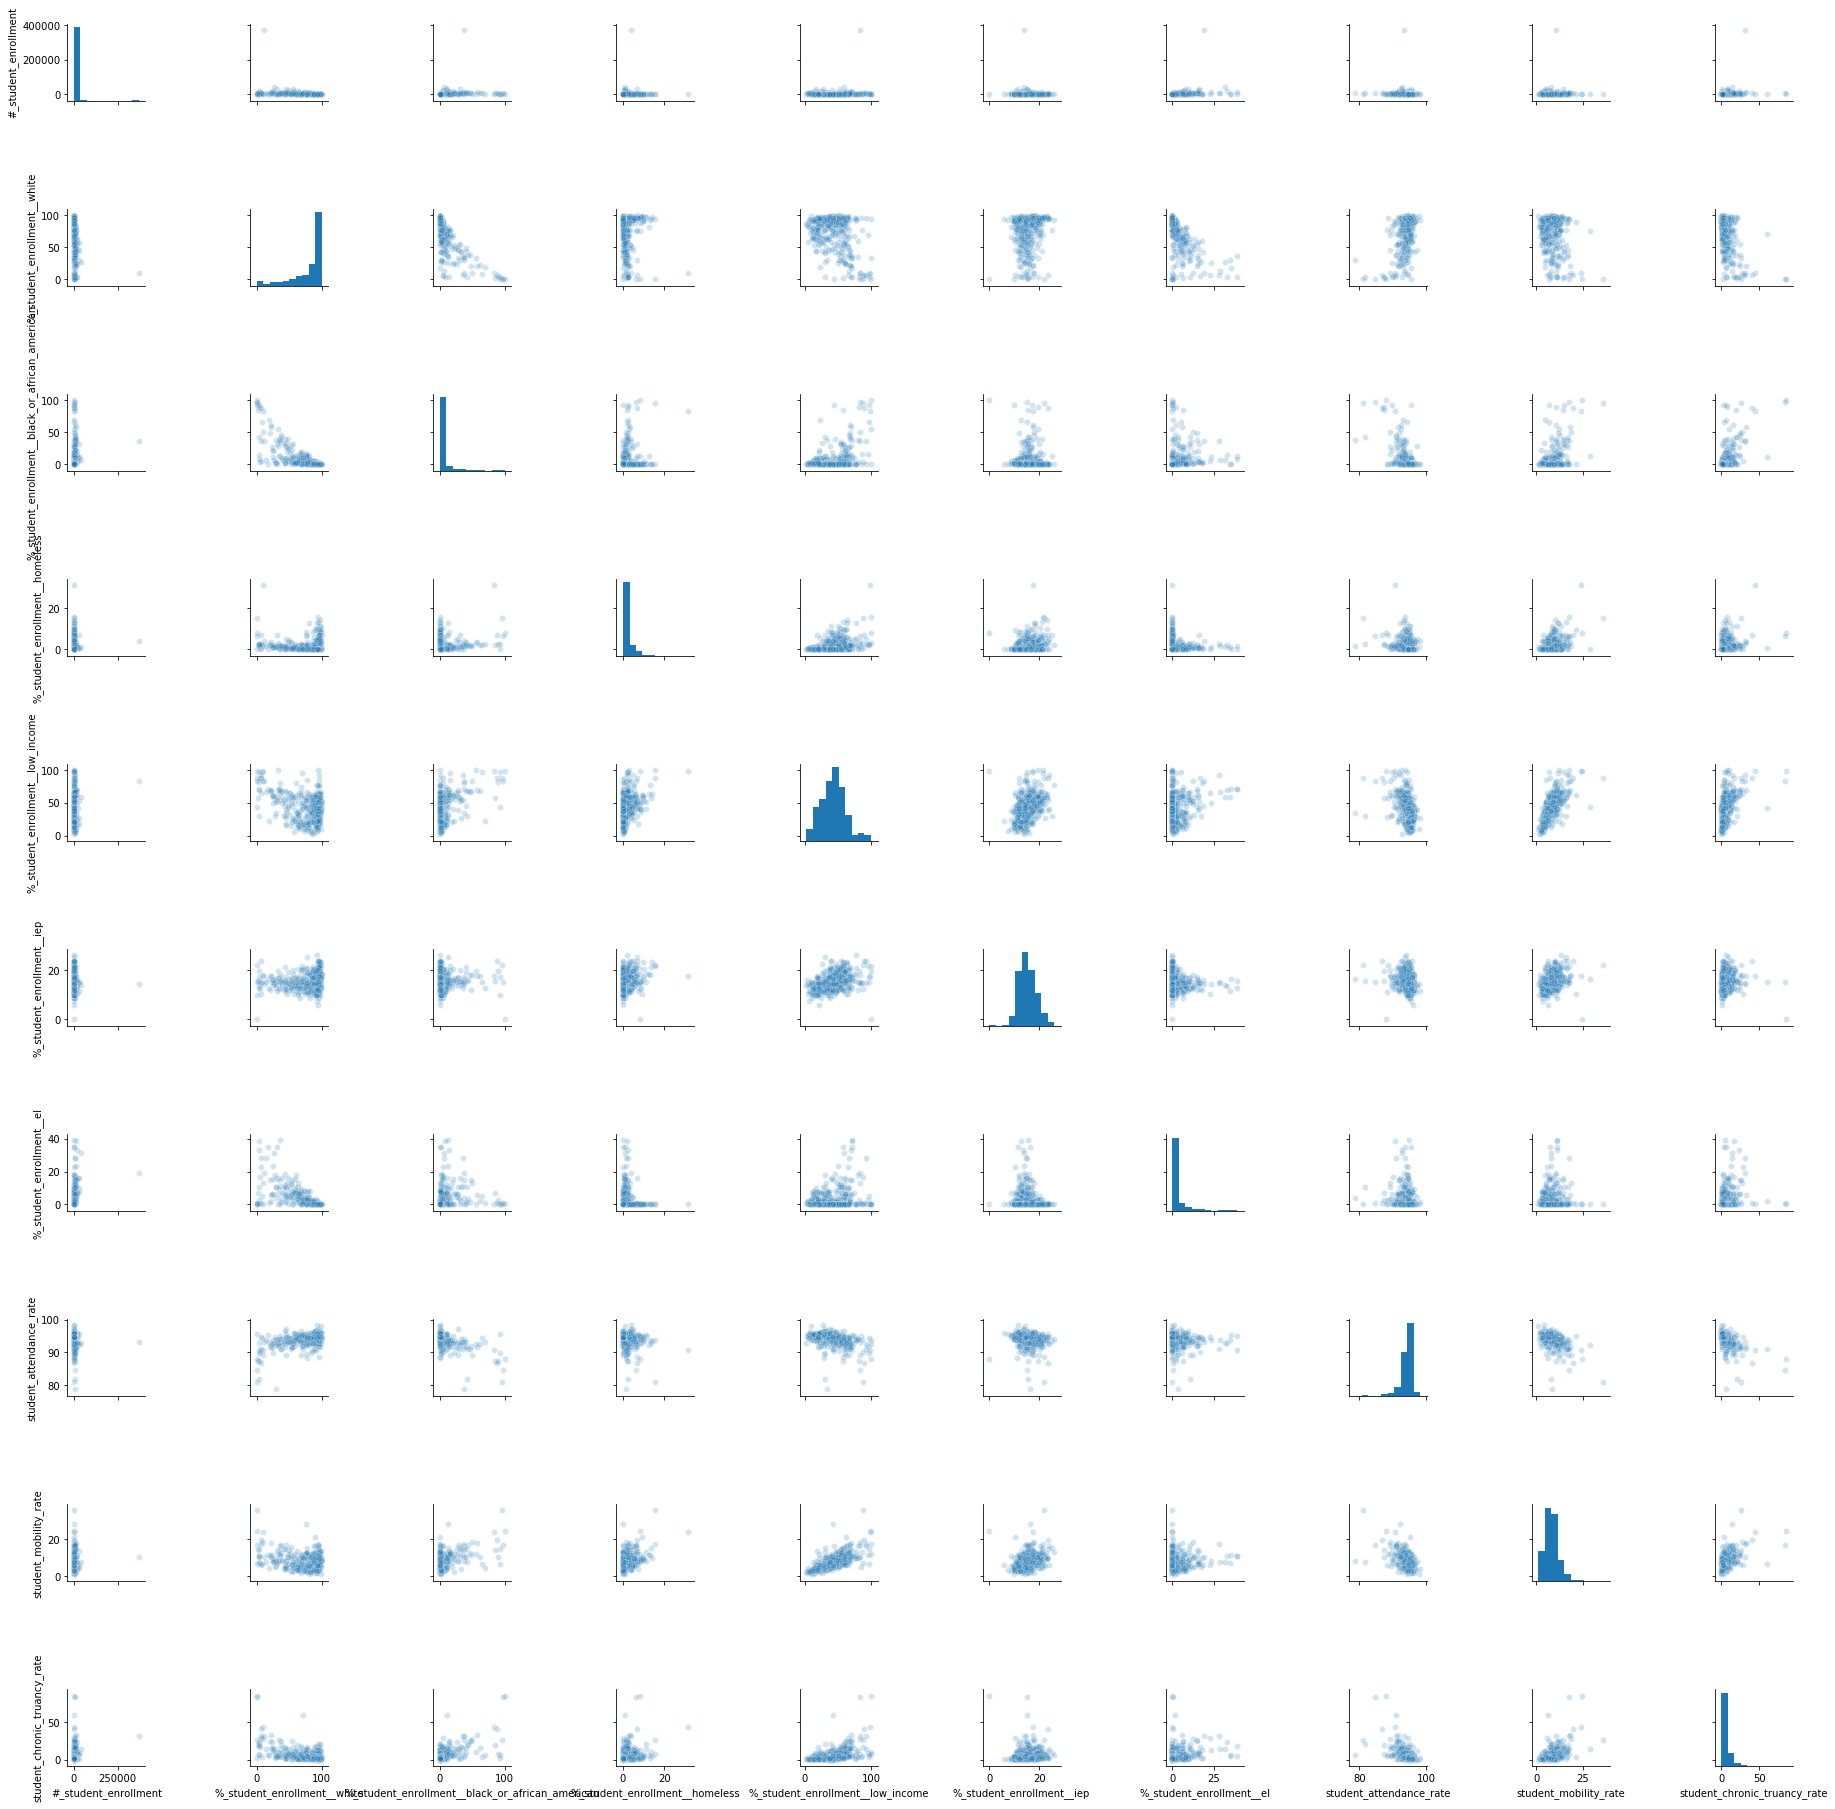

In [67]:
eda_column_subset(few_nulls, student_demo_cols)

In [ ]:
# DESCRIPTIVE STATS

# order of mag increase from 99.5% to 99.9% in student enrollment
# prob no district with 0% white students -> likely handled nulls incorrectly
# % low_income jumps from 90th percentile to max (mid 60's to mid 90's)
# pretty long tail for truancy as well
# attendance and mobility also pretty normal

# CONCLUSION: def dropping super huge district; consider dropping homeless outlier

In [ ]:
# PAIR PLOT

# low income and iep are fairly normal
# black and white seems neg correl (duh)
# one district with low enrollment and a high homeless population (that district is also v black)
# attendance and mobility are normal-ish; low income and iep even more so

In [ ]:
# CORRELATIONS

# mobility correl with lots of stuff (black, homeless, low-income, iep, truancy)
# black and white are highly neg correl (duh)
# attendance, mobility, truancy => lots of correlations
# nothing is SUPER bad

In [115]:
# homeless, low-income, iep, el (all might be valueable)
    # racial %'s correl with above => omit racial breakdown
# keep attendence, mobility, chronic (all pretty correl, mob <-> low-income also highly correl)

student_keep = [
    '#_student_enrollment',
    '%_student_enrollment__homeless',
    '%_student_enrollment__low_income',
    '%_student_enrollment__iep',
    '%_student_enrollment__el',
    'student_attendance_rate',
    'student_mobility_rate',
    'student_chronic_truancy_rate',
]

In [69]:
few_nulls['#_student_enrollment'].sort_values(ascending=False)


1415    372214.0
2837     38764.0
219      28144.0
2346     27859.0
4444     27102.0
          ...   
2557       185.0
2574       168.0
4364       134.0
3525       125.0
4110       124.0
Name: #_student_enrollment, Length: 474, dtype: float64

In [70]:
few_nulls = few_nulls[few_nulls['#_student_enrollment'] < 372214]

In [ ]:
# few_nulls[few_nulls['%_student_enrollment__homeless'] > 20][student_demo_cols  + ['district']]
# few_nulls = few_nulls[few_nulls['%_student_enrollment__homeless'] < 20]
# # district has more than double the homelessness rate of next 

## Teacher Stats

In [71]:
teacher_cols = [
    '%_of_teachers__white',
    '%_of_teachers__black_or_african_american',
    'avg_teaching_exp',
    'bachelor_degree',
    'masters_degree',
    'pupil_teacher_ratio__high_school',
    'pupil_certified_staff_ratio',
    'teacher_avg_salary',
    'teacher_retention_rate',
    'teacher_attendace_rate',
    'teacher_evaluation_rate',
]

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


,%_of_teachers__white,%_of_teachers__black_or_african_american,avg_teaching_exp,bachelor_degree,masters_degree,pupil_teacher_ratio__high_school,pupil_certified_staff_ratio,teacher_avg_salary,teacher_retention_rate,teacher_attendace_rate,teacher_evaluation_rate
count,473.000000,473.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,468.000000,467.000000
mean,93.317336,1.421142,13.890890,50.480720,48.974364,15.781568,10.540466,55607.328199,86.705720,72.632051,98.652034
std,12.477551,5.808350,2.053411,18.002051,18.145616,4.479581,1.864803,15522.642583,6.573358,12.425387,2.820786
min,0.000000,0.000000,3.200000,5.200000,0.000000,5.100000,5.300000,33438.980000,56.000000,1.800000,75.000000
10%,85.920000,0.000000,11.410000,24.720000,26.600000,9.600000,8.100000,41253.791000,78.220000,57.140000,95.760000
25%,92.500000,0.000000,12.800000,37.775000,35.950000,12.600000,9.200000,45423.630000,83.500000,66.175000,98.250000
50%,96.800000,0.000000,13.900000,51.500000,48.050000,16.250000,10.500000,51505.340000,88.100000,73.700000,100.000000
75%,99.400000,0.500000,15.100000,63.325000,61.975000,18.925000,11.725000,60358.987500,91.500000,80.725000,100.000000
90%,100.000000,2.380000,16.400000,73.090000,74.490000,20.980000,13.000000,75040.457000,93.400000,87.130000,100.000000
max,100.000000,70.000000,20.400000,88.900000,94.800000,33.900000,16.200000,114773.460000,99.000000,100.000000,100.000000


<Figure size 2880x2880 with 0 Axes>

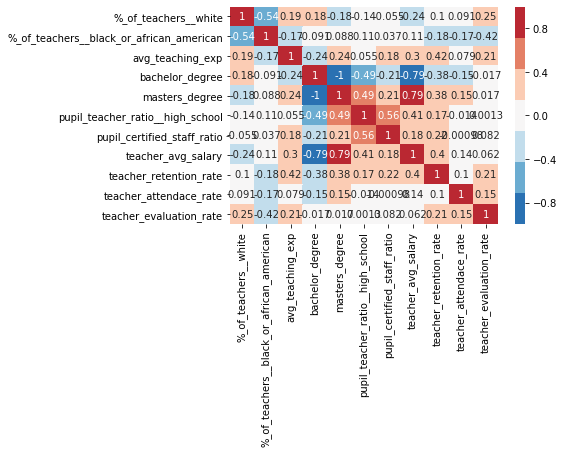

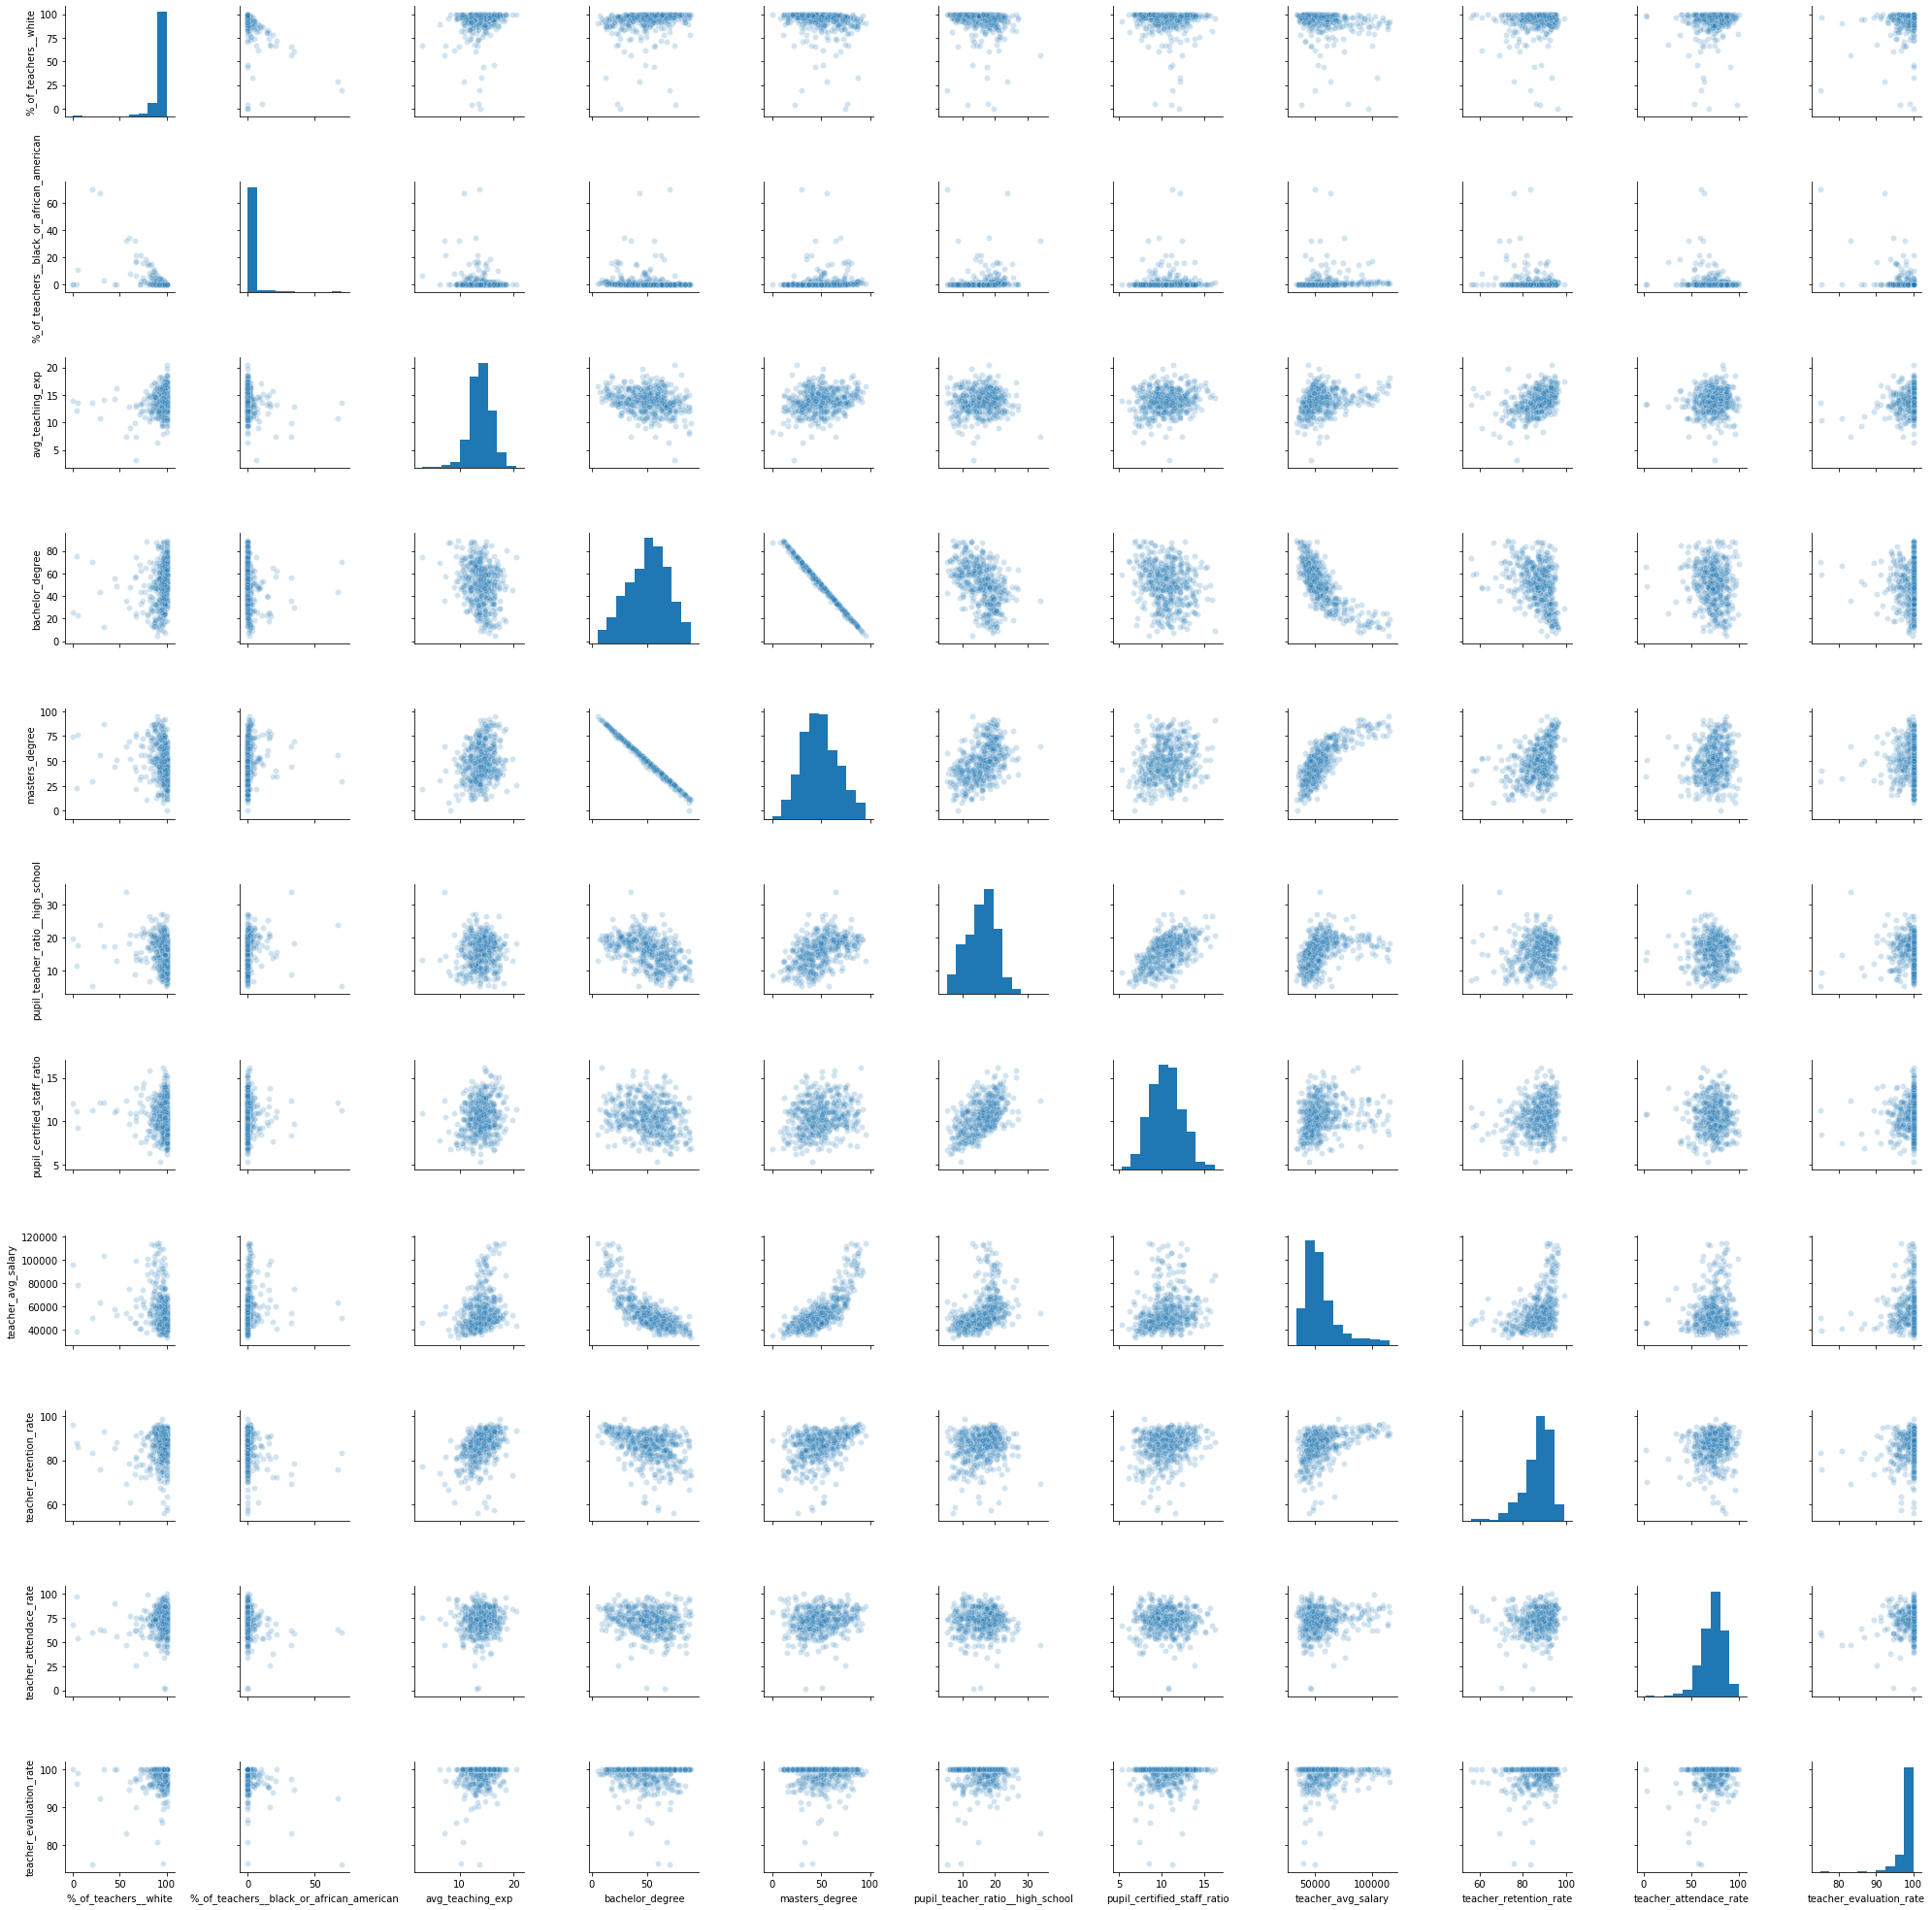

In [73]:
eda_column_subset(few_nulls, teacher_cols)

In [ ]:
# DESCRIPTIVE STATS

# teacher attendence rate of 1.8% has got to be an outlier/just plain wrong
# also a little skeptical of 0% white teachers => whole null => 0 strategy might be too simple

In [ ]:
# CORRELATIONS

# teacher salary super correlated with bachelor and master (not merit based)
# bachelor and masters are basically the same
# decently high correl btwn both pupil ratios / teacher retention and bach/mast/sal 

# Conlcusion: probably only choose one of those three fields to put in the model

In [ ]:
# PAIR PLOT

# Teacher evalutation, racial makeup don't have much variance (looksl ike lots of "ceilig" effect)

In [114]:
# choose bachelors (drop masters/salary)
# drop eval rate, white, black (super clustered around extremes)
# pick teacher over certified ratio (not crazy correl so could keep both :shrug:)

teacher_keep = [
    'avg_teaching_exp',
    'bachelor_degree',
    'pupil_teacher_ratio__high_school',
    'teacher_retention_rate',
    'teacher_attendace_rate',
]

## Funding Columns

In [74]:
few_nulls.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473 entries, 0 to 4732
Data columns (total 337 columns):
unnamed:_0                                                                        int64
rcdts                                                                             object
type                                                                              object
district                                                                          object
city                                                                              object
county                                                                            object
district_type                                                                     object
district_size                                                                     object
#_student_enrollment                                                              float64
%_student_enrollment__white                                                       float64
%_

In [85]:
funding_cols = [
    '%_ebf_capacity_to_meet_expectations',
    'eav_per_pupil_201617',
    'local_property_taxes_201617__percent',
    'other_local_funding_201617__percent',
    'instructional_expenditure_per_pupil_201617',
    'supporting_services_201617__dollars_%',
    'general_admin_201617__dollars.1',
    'instruction_201617__dollars_%'
]

# local_property_taxes_201617__dollars                                              float64
# local_property_taxes_201617__percent                                              float64
# other_local_funding_201617___dollars                                              float64
# other_local_funding_201617__percent                                               float64
# general_state_aid_201617__dollars                                                 float64
# general_state_aid_201617__percent                                                 float64
# other_state_funding_201617___dollars                                              float64
# other_state_funding_201617___percent                                              float64
# federal_funding_201617__dollars                                                   float64
# federal_funding_201617__percent                                                   float64
# total_revenue_source_201617                                                       float64
# eav_per_pupil_201617                                                              float64
# total_school_tax_rate_per_$100_201617                                             float64
# instructional_expenditure_per_pupil_201617                                        float64
# operating_expenditures_201617                                                     float64
# instruction_201617__dollars                                                       float64
# instruction_201617__dollars_%                                                     float64
# general_admin_201617__dollars                                                     float64
# general_admin_201617__dollars.1                                                   float64
# supporting_services_201617__dollars                                               float64
# supporting_services_201617__dollars_%                                             float64
# other_expenditures_201617__dollars                                                float64
# other_expenditures_201617__dollars_%                                              float64
# education_fund_201617__dollars                                                    float64
# education_fund_201617__dollars_%                                                  float64
# operations/b/m_201617_dollars                                                     float64
# operations/b/m_201617_dollars_%                                                   float64
# transportation_201617__dollars                                                    float64
# transportation_201617__dollars_%                                                  float64
# debt_service_201617__dollars                                                      float64
# debt_service_201617__dollars_%                                                    float64
# tort_201617__dollars                                                              float64
# tort_201617__dollars_%                                                            float64
# munic._ret._/_soc._security_201617__dollars                                       float64
# munic._ret._/_soc._security_201617__dollars_%                                     float64
# fire_prev._&_safety_201617__dollars                                               float64
# fire_prev._&_safety_201617__dollars_%                                             float64
# capital_projects_fund_201617__dollars                                             float64
# capital_projects_fund_201617__dollars_%                                           float64
# total_expenditures_201617

,%_ebf_capacity_to_meet_expectations,eav_per_pupil_201617,local_property_taxes_201617__percent,other_local_funding_201617__percent,instructional_expenditure_per_pupil_201617,supporting_services_201617__dollars_%,general_admin_201617__dollars.1,instruction_201617__dollars_%
count,468.000000,4.680000e+02,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000
mean,74.243376,2.101257e+05,58.507265,6.259829,6732.911944,29.201282,5.405983,46.072222
std,22.175654,2.104084e+05,18.545474,3.361268,2036.520457,5.173230,2.777133,7.153122
min,47.000000,1.824680e+04,9.500000,0.500000,3555.520000,7.300000,0.700000,13.600000
10%,56.870000,7.053762e+04,32.170000,2.700000,4919.174000,23.100000,2.200000,36.670000
25%,60.800000,9.873140e+04,45.600000,4.000000,5349.797500,26.100000,3.400000,42.475000
50%,67.800000,1.359936e+05,61.250000,5.800000,6147.980000,29.700000,4.900000,46.850000
75%,78.800000,2.315085e+05,72.775000,7.825000,7443.032500,32.500000,7.100000,50.400000
90%,100.980000,4.542146e+05,83.430000,10.430000,9344.535000,35.230000,9.400000,54.100000
max,198.000000,1.856751e+06,91.300000,26.100000,15912.610000,49.700000,16.500000,65.200000


<Figure size 2880x2880 with 0 Axes>

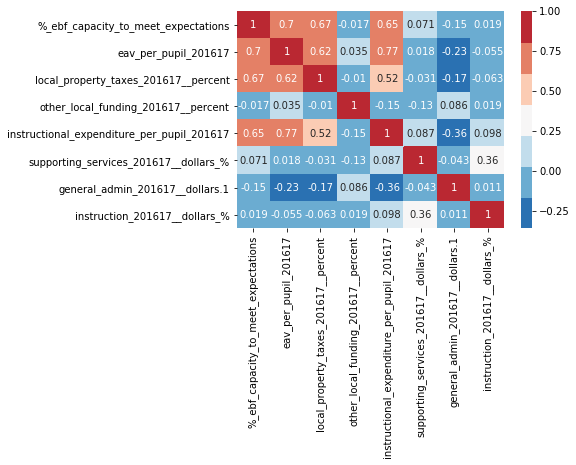

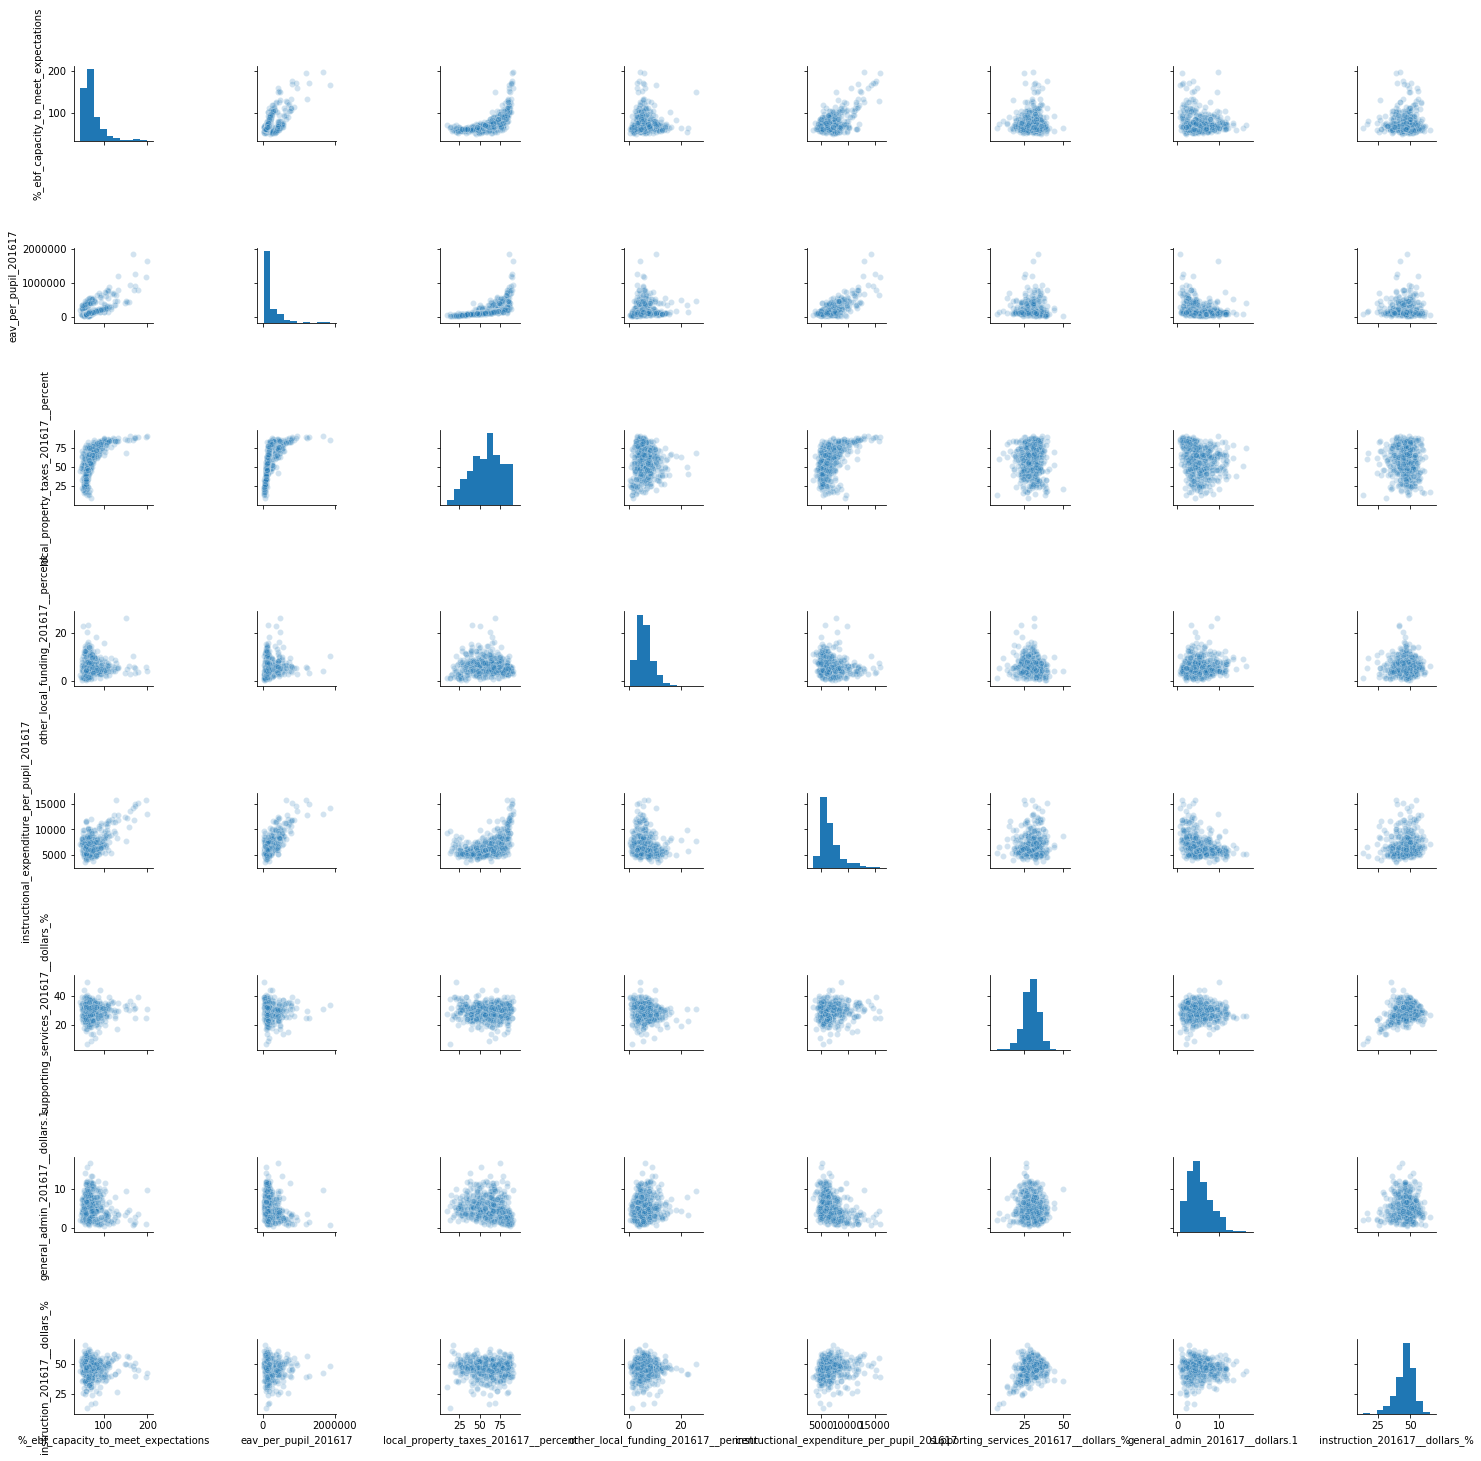

In [86]:
eda_column_subset(few_nulls, funding_cols)

In [ ]:
# DESCRIPTIVE

# Don't see any crazy outliers

In [79]:
# Correlations

# Everything aggregate is very correlated -> might just choose one metric
# Strange there's no correl between total instructional exp and % inst expenditure
# Seems like a lot of the aggregate values are correl (% capacity, eav, instr exp)
# ^^ agg also heavily correl with local % (maj or funding is local)
# Surprising inst and gen admin % aren't more related

In [80]:
# Pair Plots

# local property taxes percent is most normal

In [ ]:
# keep %EBF for agg measure
# use 

### Funding Allocations

In [110]:
few_nulls['inst_and_support'] = few_nulls['instruction_201617__dollars_%'] + few_nulls['supporting_services_201617__dollars_%']
few_nulls['admin_other'] = few_nulls['general_admin_201617__dollars.1'] + few_nulls['other_expenditures_201617__dollars_%']

allocations = [
    'instruction_201617__dollars_%',
    'general_admin_201617__dollars.1',
    'other_expenditures_201617__dollars_%',
    'supporting_services_201617__dollars_%',
    'admin_other',
    'inst_and_support'
]

# instruction_201617__dollars_%                                                     float64
# general_admin_201617__dollars                                                     float64
# general_admin_201617__dollars.1                                                   float64
# supporting_services_201617__dollars                                               float64
# supporting_services_201617__dollars_%                                             float64
# other_expenditures_201617__dollars                                                float64
# other_expenditures_201617__dollars_%                                              float64
# education_fund_201617__dollars                                                    float64
# education_fund_201617__dollars_%                                                  float64
# operations/b/m_201617_dollars                                                     float64
# operations/b/m_201617_dollars_%                                                   float64
# transportation_201617__dollars                                                    float64
# transportation_201617__dollars_%                                                  float64
# debt_service_201617__dollars                                                      float64
# debt_service_201617__dollars_%                                                    float64
# tort_201617__dollars                                                              float64
# tort_201617__dollars_%                                                            float64
# munic._ret._/_soc._security_201617__dollars                                       float64
# munic._ret._/_soc._security_201617__dollars_%                                     float64
# fire_prev._&_safety_201617__dollars                                               float64
# fire_prev._&_safety_201617__dollars_%                                             float64
# capital_projects_fund_201617__dollars                                             float64
# capital_projects_fund_201617__dollars_%

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


,instruction_201617__dollars_%,general_admin_201617__dollars.1,other_expenditures_201617__dollars_%,supporting_services_201617__dollars_%,admin_other,inst_and_support
count,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000
mean,46.072222,5.405983,19.319872,29.201282,24.725855,75.273504
std,7.153122,2.777133,10.557178,5.173230,10.223550,10.221597
min,13.600000,0.700000,2.300000,7.300000,7.900000,20.900000
10%,36.670000,2.200000,9.170000,23.100000,14.200000,63.010000
25%,42.475000,3.400000,12.575000,26.100000,17.800000,70.300000
50%,46.850000,4.900000,17.000000,29.700000,22.850000,77.200000
75%,50.400000,7.100000,23.900000,32.500000,29.700000,82.200000
90%,54.100000,9.400000,33.300000,35.230000,37.060000,85.800000
max,65.200000,16.500000,77.000000,49.700000,79.200000,92.100000


<Figure size 2880x2880 with 0 Axes>

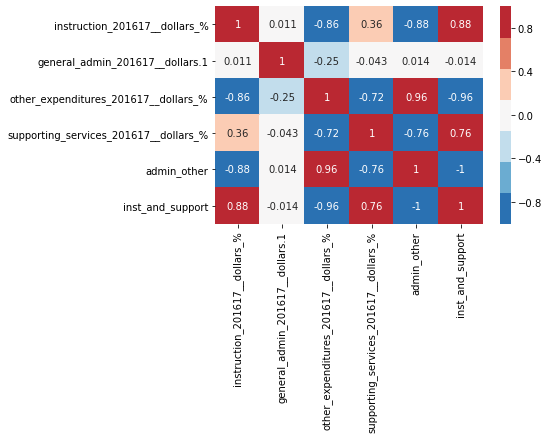

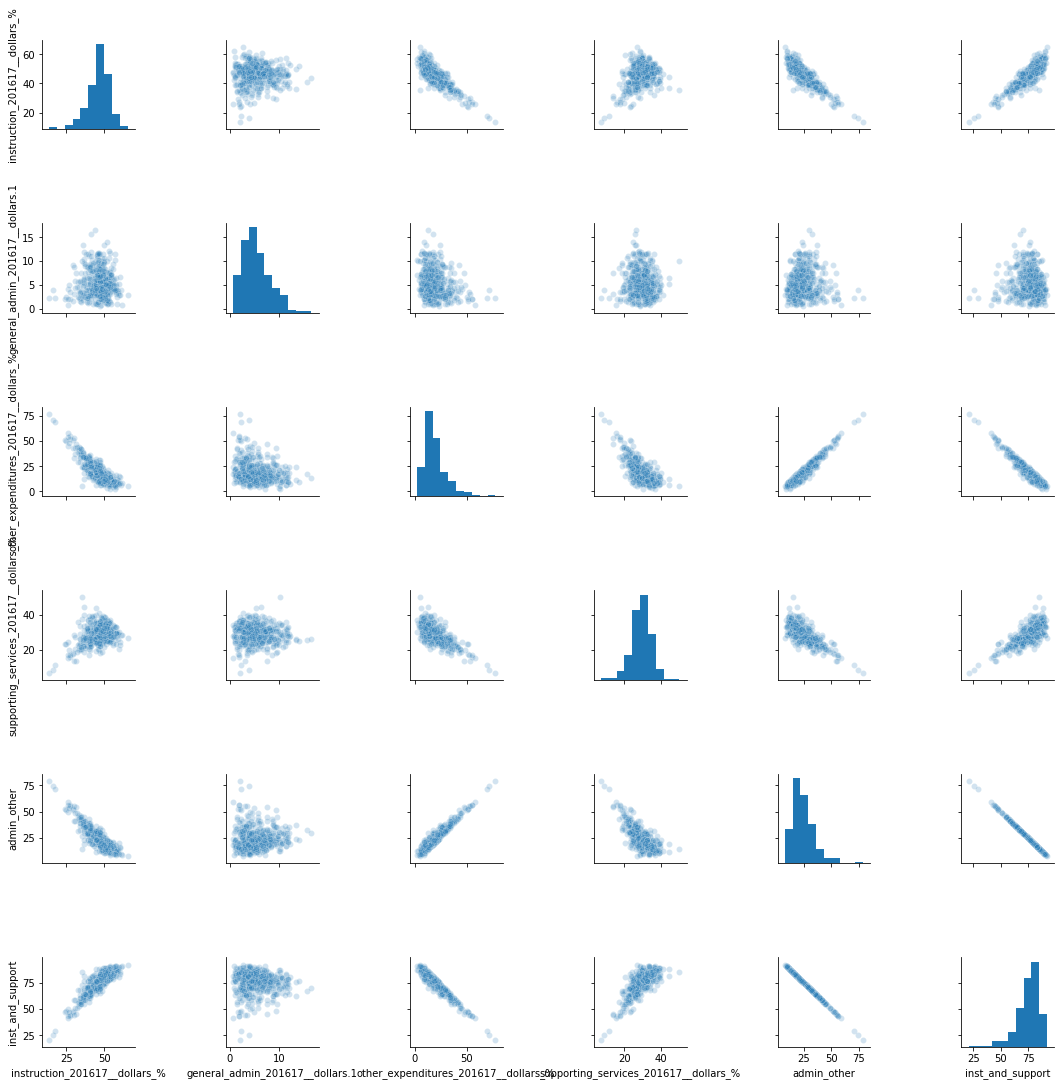

In [111]:
eda_column_subset(few_nulls, allocations)

In [ ]:
# Education and Instruction are very similar
# ^^^ those seem to be opposite "other"
# debt service seems like a big factor limiting educational expenditure (neg correl)

In [ ]:
# CONCLUSIONS

# Probably include one agg funding metric (% EBF, eav/pupil, instr eav/pupil)
# Might see if "choice" plays a role (some allocative metric - could be debt)

In [116]:
funding_keep = [
    'inst_and_support',
    '%_ebf_capacity_to_meet_expectations'
]

## Admin and Other

In [91]:
admin_other = [
    'avg_class_size__high_school',
    'admin_avg_salary',
    'principal_turnover_within_6_years', 
    'pupil_admin_ratio',
    'district_type'
]

,avg_class_size__high_school,admin_avg_salary,principal_turnover_within_6_years,pupil_admin_ratio
count,473.000000,472.000000,472.000000,472.000000
mean,16.640592,97757.144386,1.644068,172.987076
std,4.341098,18801.927792,0.628758,53.834771
min,5.000000,47470.670000,0.000000,62.500000
10%,11.000000,78295.262000,1.000000,110.020000
25%,14.000000,86191.665000,1.000000,134.675000
50%,17.000000,95901.665000,2.000000,172.350000
75%,20.000000,105911.262500,2.000000,204.100000
90%,22.000000,118230.650000,2.000000,234.390000
max,28.000000,260021.320000,4.000000,597.000000


<Figure size 2880x2880 with 0 Axes>

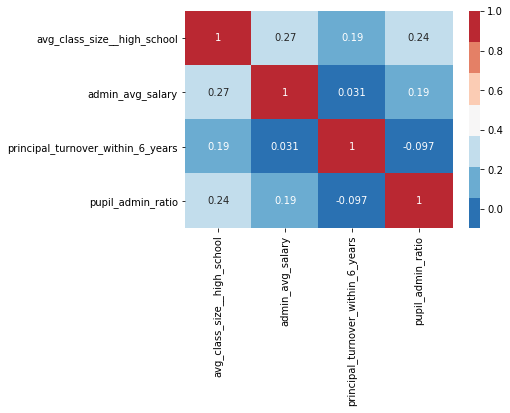

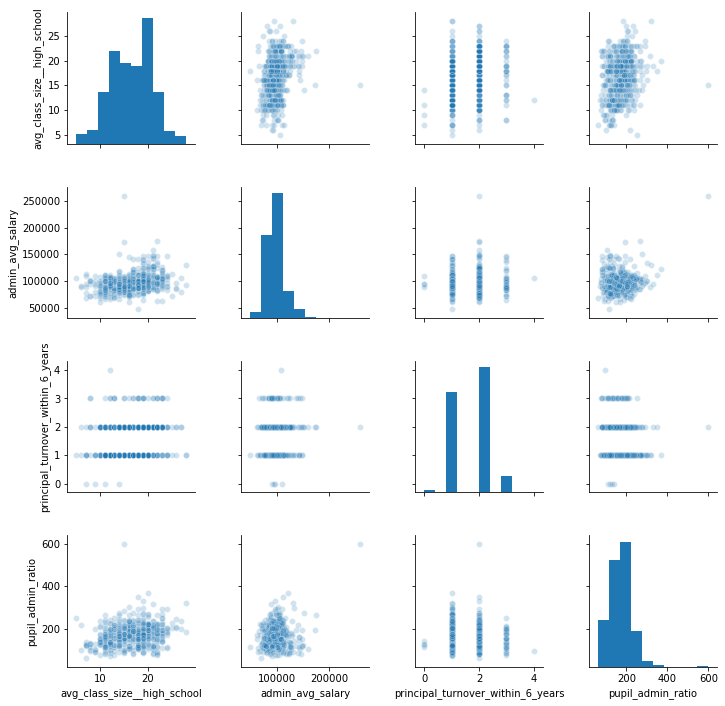

In [92]:
eda_column_subset(few_nulls, admin_other)

In [93]:
few_nulls.district_type.value_counts()

UNIT           374
HIGH SCHOOL     98
Name: district_type, dtype: int64

In [ ]:
# Observations

# looks like a big outlier in both admin_avg_salary and pupil_admin_ratio
# (one district has very few admin that are paid a lot)

In [117]:
admin_keep = [
    'avg_class_size__high_school',
    'admin_avg_salary',
    'principal_turnover_within_6_years', 
    'pupil_admin_ratio',
    'district_type'
]

## Student Performance Variables

In [102]:
few_nulls['avg_sat_math'] = ((few_nulls['sat_math_total_students_level_1_%'] * 1) +\
    (few_nulls['sat_math_total_students_level_2_%'] * 2) +\
    (few_nulls['sat_math_total_students_level_3_%'] * 3) +\
    (few_nulls['sat_math_total_students_level_4_%'] * 4)) / 100

In [103]:
few_nulls['avg_sat_reading'] = ((few_nulls['sat_reading_total_students_level_1_%'] * 1) +\
    (few_nulls['sat_reading_total_students_level_2_%'] * 2) +\
    (few_nulls['sat_reading_total_students_level_3_%'] * 3) +\
    (few_nulls['sat_reading_total_students_level_4_%'] * 4)) / 100

In [112]:
few_nulls['avg_sat_both'] = (few_nulls['avg_sat_math'] + few_nulls['avg_sat_reading']) / 2

In [104]:
outcome_columns = [
    'avg_sat_math',
    'avg_sat_reading',
    '%_students_sat_math_participation',
    '%_sat_ela_participation',
    'community_college_remediation_%',
    'community_college_remediation_reading_%',
    'community_college_remediation_math_%',
    'high_school_4year_graduation_rate__total',
]

,avg_sat_math,avg_sat_reading,%_students_sat_math_participation,%_sat_ela_participation,community_college_remediation_%,community_college_remediation_reading_%,community_college_remediation_math_%,high_school_4year_graduation_rate__total
count,473.000000,473.000000,473.000000,473.000000,463.000000,463.000000,463.000000,472.000000
mean,1.972632,2.172645,98.702114,98.702114,40.438229,11.926566,31.213607,88.992797
std,0.347916,0.314977,2.071251,2.071251,17.633403,11.360751,16.502225,7.277662
min,1.083000,1.150000,86.200000,86.200000,0.000000,0.000000,0.000000,55.100000
10%,1.550800,1.791200,96.400000,96.400000,17.600000,0.000000,9.500000,78.930000
25%,1.733000,2.000000,98.200000,98.200000,28.600000,1.950000,20.000000,85.700000
50%,1.950000,2.145000,99.600000,99.600000,40.300000,9.700000,30.800000,90.600000
75%,2.187000,2.359000,100.000000,100.000000,52.750000,18.800000,41.950000,94.000000
90%,2.416800,2.564000,100.000000,100.000000,62.060000,27.760000,53.460000,96.700000
max,3.209000,3.229000,100.000000,100.000000,100.000000,61.500000,100.000000,100.000000


<Figure size 2880x2880 with 0 Axes>

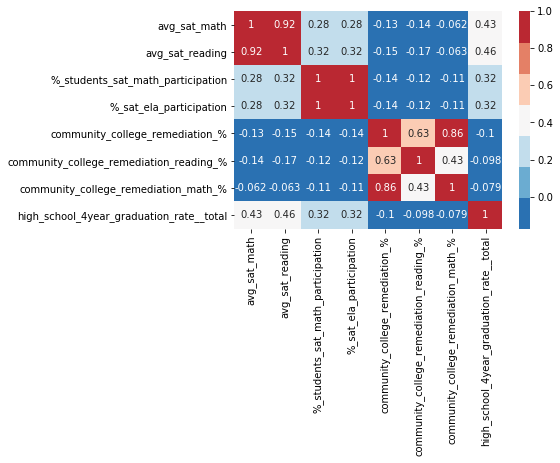

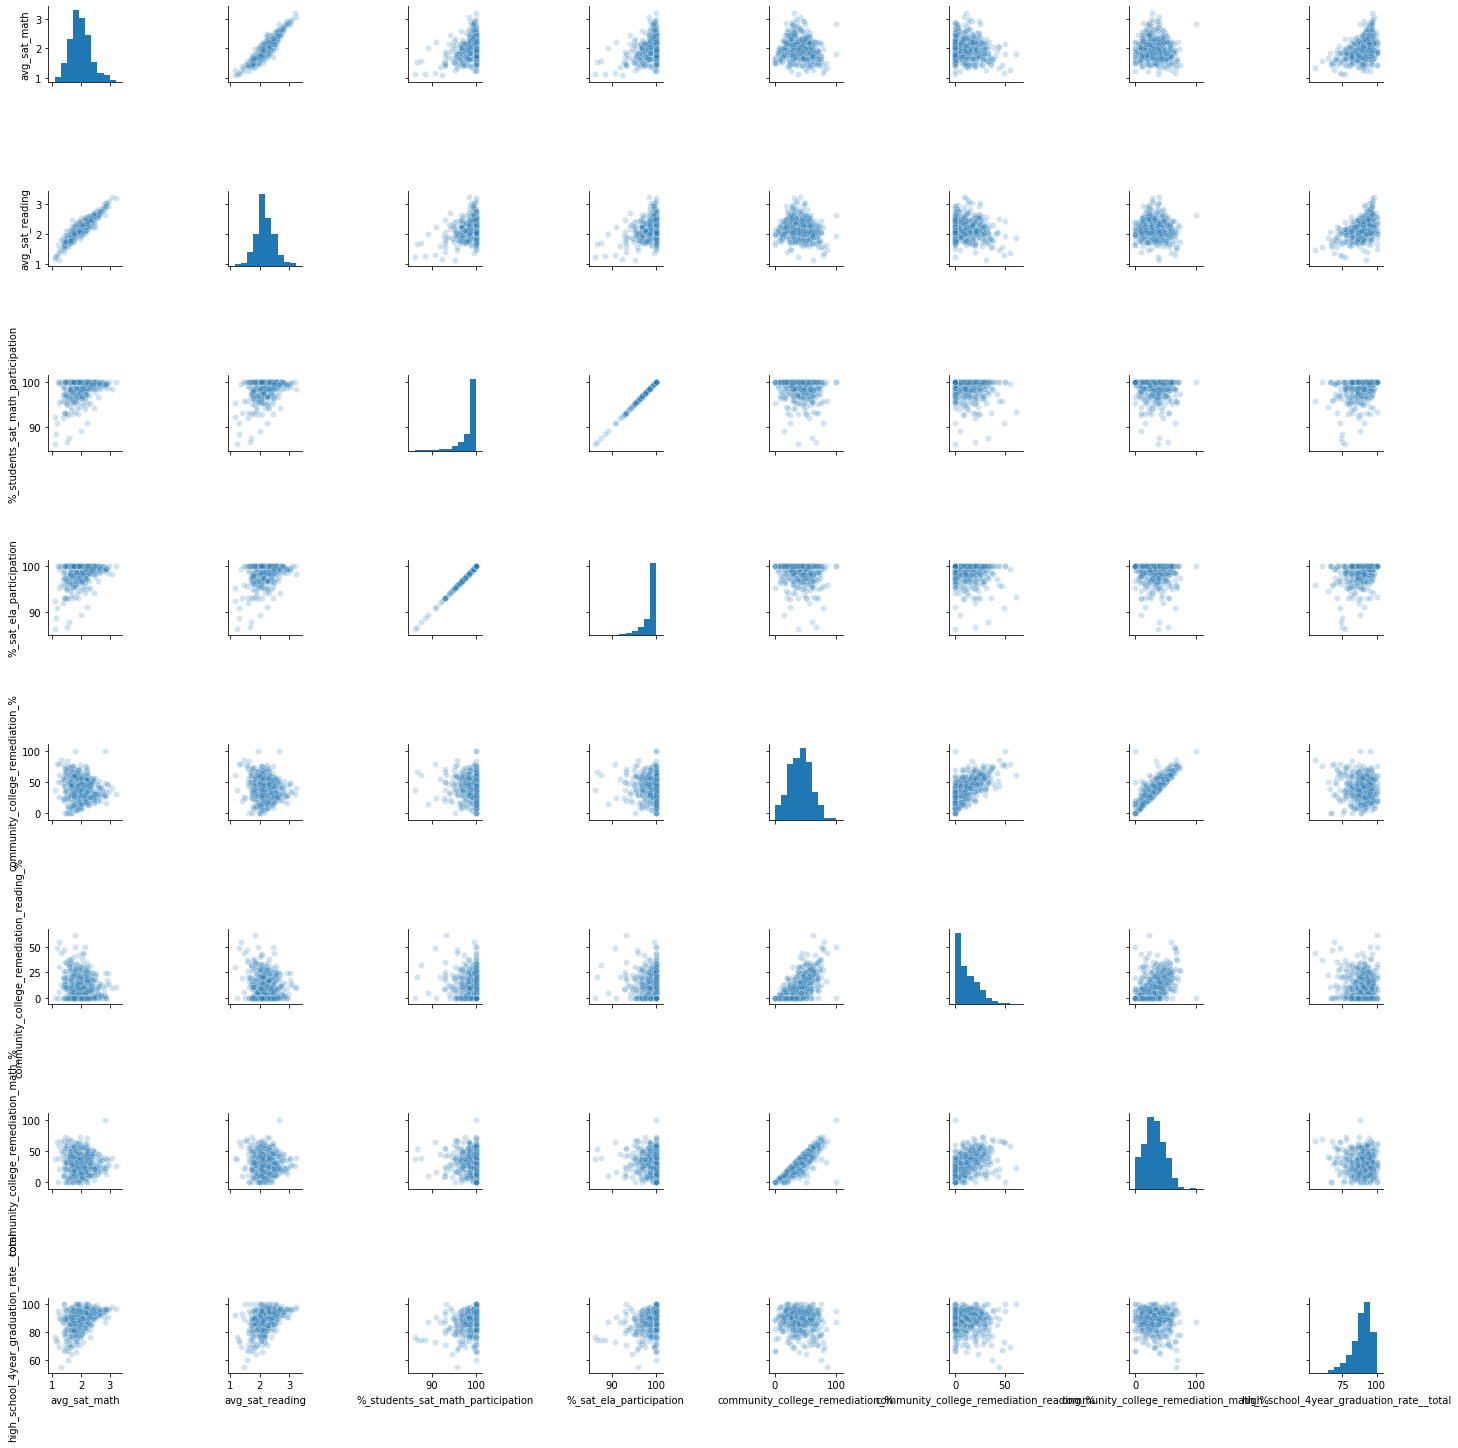

In [105]:
eda_column_subset(few_nulls, outcome_columns)

In [ ]:
# OBSERVATIONS

# Math and reading participation are the same
# Scores in one are highly predictive of the other
# Graduation and SAT scores less correl than I thought
# Tons of edge effects with community college remediation (both 0 and 100) => prob bad metric
# Not sure if SAT participation is important
    # Was worried only "good" students took the test but the correl are slightly positive (more part => higher scores)

# Could consider averaging Reading and Math Scores (or doing a multi-ind var with both HS grad and SAT)

In [113]:
ind_vars = [
    'avg_sat_both'
]



# Data (Almost) Ready for Modeling

In [118]:
all_modeling_columns = ind_vars + student_keep + teacher_keep + funding_keep + admin_keep

In [122]:
all_modeling_columns

['avg_sat_both',
 '#_student_enrollment',
 '%_student_enrollment__homeless',
 '%_student_enrollment__low_income',
 '%_student_enrollment__iep',
 '%_student_enrollment__el',
 'student_attendance_rate',
 'student_mobility_rate',
 'student_chronic_truancy_rate',
 'avg_teaching_exp',
 'bachelor_degree',
 'pupil_teacher_ratio__high_school',
 'teacher_retention_rate',
 'teacher_attendace_rate',
 'inst_and_support',
 '%_ebf_capacity_to_meet_expectations',
 'avg_class_size__high_school',
 'admin_avg_salary',
 'principal_turnover_within_6_years',
 'pupil_admin_ratio',
 'district_type']

In [120]:
almost_modeling_data = few_nulls[all_modeling_columns]

In [121]:
almost_modeling_data.to_csv('../data/interim/high_school_districts_almost_ready.csv')

In [ ]:
# DATA MANIPULATION I DID

# Nulls: Replace %'s with zero if blank (iep, homeless, low_income, el)
# Dropped any district that didn't have SAT scores
# Dropped Chicago (two orders of magnitude bigger enrollment)
# Summed instructional and support services expenditures
    # Rationale: more directly student related compared to "other" or "admin"

In [ ]:
# MORE CLEANING THAT COULD BE DONE

# one district has very high pupil-staff ratio and high avg staff salary (few highly paid staff)
# low teacher attendence is prob wrong (1.8%)